## Sztuczne sieci neuronowe - laboratorium 4

### Sieci neuronowe

Podczas poprzednich dwóch ćwiczeń:
- poszukiwaliśmy parametrów **modelu liniowego**, aby dopasować go do danych
- zdefiniowaliśmy funkcję straty dla regresji - błąd średniokwardratowy (MSE)
- użyliśmy algorytmu najszybszego spadku, aby znaleźć optymalne parametry modelu
- najpierw robiliśmy wsystkie te kroki "ręcznie", potem poznaliśmy możliwości PyTorch autograd i torch.optim.

Dziś zastąpimy model liniowy prostą siecią neuronową.

**Sieć neuronowa** to przykład modelu bardziej złożonego niż model liniowy.

Algorytmy uczenia sieci neuronowych nie różnią się jednak szczególnie od poznanych już na zajęciach - powszechnie stosuje się algorytm najszybszego spadku lub jeden z jego bardziej zaawansowanych wariantów (SGD+momentum, Adagrad, RMSProp, Adam, ...).

Podstawowym składnikiem sieci neuronowej jest **neuron**.
Równanie neuronu można zapisać jako `o = f(w * x + b)`, gdzie `x` to dane wejściowe, `w` i `b` to parametry (wagi), a `f` to funkcja aktywacji. Neurony składają się na **warstwy** tworzące sieć neuronową.

Najpierw wrócimy jednak do modelu liniowego.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
data_unknown = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
data_celsius = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]

t_u = torch.tensor(data_unknown)
t_c = torch.tensor(data_celsius)

t_u_mean = t_u.mean()
t_u_std = t_u.std()

t_un = (t_u - t_u_mean) / t_u_std

t_c_mean = t_c.mean()
t_c_std = t_c.std()

t_cn = (t_c - t_c_mean) / t_c_std

### Zbiór uczący i walidacyjny

Zadaniem modelu nie jest zapamiętanie danych uczących, ale nauczenie się wzorców, które "poradzą sobie" także z przykładami niewidzianymi podczas treningu. Zbiór danych - w przypadku walidacji prostej - należy podzielić na dwa podzbiory, a następnie uczyć model na jednym z nich (zbiór uczący) i sprawdzać jego działanie na innym (zbiór walidacyjny/testowy).

#### Ćwiczenie
Podziel zbiór danych na zbiór uczący i walidacyjny, losując 20% elementów (na podstawie ich indeksów) tensora `t_un` do zbioru walidacyjnego. Wykorzystaj funkcję `torch.randperm`.

https://pytorch.org/docs/stable/generated/torch.randperm.html

Przypisz podzielone tensory `t_u`, `t_un` i `t_c` do zmiennych `train_t_u`, `val_t_u` itd.

In [4]:
indices = torch.randperm(len(t_un))
split_idx = int(len(t_un) * 0.8)
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]
train_t_u = t_un[train_indices]
print(train_t_u)

tensor([ 0.9862, -0.2020, -0.9565,  0.5109, -0.1723, -1.0635, -1.7823,  0.2436])


In [5]:
val_t_u = t_un[val_indices]
print(val_t_u)

tensor([0.2673, 1.7883, 0.3802])


In [6]:
train_t_c = t_cn[train_indices]
print(train_t_c)

tensor([ 1.1399, -0.4885, -1.0856,  0.2714, -0.2714, -0.8142, -1.5741,  0.3800])


In [7]:
val_t_c = t_cn[val_indices]
print(val_t_c)

tensor([0.0543, 1.8998, 0.4885])


#### Pętla treningowa - walidacja modelu

W procesie poszukiwania parametrów modelu dokonujemy aktualizacji parametrów modelu na podstawie funkcji straty dla zbioru uczącego. Należy także monitorować funkcję straty na zbiorze walidacyjnym, na przykład w celu uniknięcia przeuczenia modelu.

Jako że na zbiorze walidacyjnym nie musimy wykonywać kroku "wstecz", nie wywołujemy `val_loss.backward()`. W związku z tym nie ma potrzeby budowania grafu - w celu przyspieszenia obliczeń fragmenty kodu związane z walidacją możemy zamknąć w bloku `with torch.no_grad()`.

In [8]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

### torch.nn

https://pytorch.org/docs/stable/nn.html

Moduł PyTorcha `torch.nn` zawiera implementacje różnych elementów (warstw) tworzących sieci neuronowe. Elementy te w PyTorchu nazywa się modułami ("modules") - realizowane są jako klasy dziedziczące po klasie bazowej `nn.Module`.

Najprostszym przykładem modułu jest warstwa liniowa (gęsta) `nn.Linear`, która jest równoważna modelowi liniowemu (funkcja `model`) z przykładu z termometrami z poprzednich ćwiczeń.

Konstruktor `nn.Linear` przyjmuje 3 argumenty - rozmiar wejścia (liczbę cech - oraz przypisanych im wag `w`), rozmiar wyjścia oraz argument True/False, czy uwzględniać wyraz wolny (`b`) - domyślnie True.

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

### Ćwiczenie

Stwórz model liniowy używając modułu `nn.Linear`. Poeksperymentuj z różnymi wartościami argumentów konstruktora: `in_features`, `out_features` oraz `bias`. Zobacz, jak zmienia się zawartość atrybutów `linear_model.weight` i `linear_model.bias`. Sprawdź zawartość `list(model.parameters())`.

In [9]:
linear_model = nn.Linear(1, 1)
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

Parameter containing:
tensor([[0.2733]], requires_grad=True)
Parameter containing:
tensor([0.2904], requires_grad=True)
[Parameter containing:
tensor([[0.2733]], requires_grad=True), Parameter containing:
tensor([0.2904], requires_grad=True)]


In [10]:
linear_model = nn.Linear(1, 1, bias=False)
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

Parameter containing:
tensor([[0.8843]], requires_grad=True)
None
[Parameter containing:
tensor([[0.8843]], requires_grad=True)]


In [11]:
linear_model = nn.Linear(2, 1)
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

Parameter containing:
tensor([[ 0.0857, -0.4556]], requires_grad=True)
Parameter containing:
tensor([-0.5692], requires_grad=True)
[Parameter containing:
tensor([[ 0.0857, -0.4556]], requires_grad=True), Parameter containing:
tensor([-0.5692], requires_grad=True)]


In [12]:
linear_model = nn.Linear(1, 2)
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

Parameter containing:
tensor([[0.3259],
        [0.2079]], requires_grad=True)
Parameter containing:
tensor([0.8053, 0.3223], requires_grad=True)
[Parameter containing:
tensor([[0.3259],
        [0.2079]], requires_grad=True), Parameter containing:
tensor([0.8053, 0.3223], requires_grad=True)]


In [13]:
linear_model = nn.Linear(2, 2)
print(linear_model.weight)
print(linear_model.bias)
print(list(linear_model.parameters()))

Parameter containing:
tensor([[-0.2036,  0.3917],
        [-0.0315,  0.1826]], requires_grad=True)
Parameter containing:
tensor([-0.6044, -0.3074], requires_grad=True)
[Parameter containing:
tensor([[-0.2036,  0.3917],
        [-0.0315,  0.1826]], requires_grad=True), Parameter containing:
tensor([-0.6044, -0.3074], requires_grad=True)]


In [14]:
model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)
print(list(model.parameters()))

Parameter containing:
tensor([[0.8004]], requires_grad=True)
Parameter containing:
tensor([-0.1037], requires_grad=True)
[Parameter containing:
tensor([[0.8004]], requires_grad=True), Parameter containing:
tensor([-0.1037], requires_grad=True)]


#### Ćwiczenie
W przypadku "wrzucania" do modelu wielu (N) obserwacji jednocześnie (tzw. batch danych) należy zadbać o odpowiednie wymiary tensora (tu: tensor kolumnowy N x 1). W tym celu należy użyć funkcji `unsqueeze`.

https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

Sprawdź, jaką wartość ma atrybut `.shape` tensora `t_un` przed i po użyciu funkcji `unsqueeze`.

Następnie przepuść tensor zawierający znormalizowane dane wejściowe przez model (dobierz odpowiednie rozmiary wejścia i wyjścia `nn.Linear`). W tym celu można po prostu wywołać `model(dane_wejsciowe)` - jest to wywołanie metody `__call__` klasy `nn.Linear`.

In [15]:
print(t_un.shape)
t_un_uns = t_un.unsqueeze(1)
print(t_un_uns.shape)

torch.Size([11])
torch.Size([11, 1])


In [16]:
print(model(t_un_uns))

tensor([[-0.8692],
        [ 0.0913],
        [ 0.2006],
        [ 1.3276],
        [ 0.1103],
        [-0.2416],
        [-0.9548],
        [-1.5302],
        [-0.2654],
        [ 0.3053],
        [ 0.6857]], grad_fn=<AddmmBackward0>)


#### Ćwiczenie

Uzupełnij poniższe komórki:
- uzupełnij funkcję `training_loop_torch_nn`
- zainicjalizuj model liniowy i optymalizator SGD dla learning rate 0.01
- następnie wywołaj ją dla 1000 iteracji (epok)

`torch.nn` zawiera także implementacje różnych funkcji straty. Przy wywołaniu pętli treningowej podaj funkcję straty `nn.MSELoss()`.

Po wywołaniu pętli uczącej zajrzyj w parametry modelu - atrybuty `.weight` i `.bias`



In [17]:
# ZASTĄP SŁOWA None KODEM / DOPISZ LINIE KODU WE WSKAZANYCH MIEJSCACH

def training_loop_torch_nn(n_iters, optimizer, model, loss_fn, train_t_u, val_t_u, train_t_c, val_t_c, verbose=True):
    for iteration in range(n_iters+1):
        train_t_p = model(train_t_u)
        loss_train = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u)
            loss_val = loss_fn(val_t_p, val_t_c)

        # zerowanie gradientów
        optimizer.zero_grad()
        # obliczenie gradientów
        loss_train.backward()
        # krok aktualizacji
        optimizer.step()

        if verbose:
            print('Epoch %d, Training loss %f, validation loss: %f' % (iteration, loss_train.item(), loss_val.item()))
    return model


In [18]:
# ZASTĄP SŁOWA None KODEM

linear_model = model
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

training_loop_torch_nn(
    n_iters = 1000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    train_t_u = train_t_u.unsqueeze(1),
    val_t_u = val_t_u.unsqueeze(1),
    train_t_c = train_t_c.unsqueeze(1),
    val_t_c = val_t_c.unsqueeze(1)
)

Epoch 0, Training loss 0.051254, validation loss: 0.137822
Epoch 1, Training loss 0.050891, validation loss: 0.136098
Epoch 2, Training loss 0.050536, validation loss: 0.134407
Epoch 3, Training loss 0.050190, validation loss: 0.132748
Epoch 4, Training loss 0.049853, validation loss: 0.131121
Epoch 5, Training loss 0.049524, validation loss: 0.129526
Epoch 6, Training loss 0.049203, validation loss: 0.127961
Epoch 7, Training loss 0.048890, validation loss: 0.126426
Epoch 8, Training loss 0.048584, validation loss: 0.124920
Epoch 9, Training loss 0.048286, validation loss: 0.123443
Epoch 10, Training loss 0.047995, validation loss: 0.121993
Epoch 11, Training loss 0.047711, validation loss: 0.120572
Epoch 12, Training loss 0.047434, validation loss: 0.119177
Epoch 13, Training loss 0.047164, validation loss: 0.117809
Epoch 14, Training loss 0.046901, validation loss: 0.116466
Epoch 15, Training loss 0.046643, validation loss: 0.115149
Epoch 16, Training loss 0.046392, validation loss:

Linear(in_features=1, out_features=1, bias=True)

In [19]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[0.9354]], requires_grad=True)
Parameter containing:
tensor([-0.0205], requires_grad=True)


### Sieć neuronowa

Zastąpimy teraz model liniowy prostą siecią neuronową. Wszystko poza modelem pozostanie bez zmian.

Będzie to najprostsza możliwa sieć neuronowa, złożona kolejno z:
- warstwy liniowej (`nn.Linear`)
- funkcji aktywacji (`nn.Tanh`, `nn.Sigmoid` lub `nn.ReLU`)
- kolejnej warstwy liniowej

Pierwsza warstwa liniowa razem z funkcją aktywacji nazywana jest warstwą ukrytą ("hidden layer").

Sieć neuronową można stworzyć z wykorzystaniem klasy `nn.Sequential`:
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

Argumentami konstruktora są kolejne warstwy sieci.

#### Ćwiczenie
Stwórz sieć neuronową zgodną z powyższym opisem. Liczba wyjść z pierwszej warstwy liniowej musi być równa liczbie wejść do drugiej warstwy liniowej. Przypisz model do zmiennej `seq_model` i sprawdź jej zawartość.

Dobór architektury (liczby warstw, liczby neuronów w warstwach, funkcji aktywacji...) jest przedmiotem eksperymentów.
Początkowo przyjmijmy funkcję aktywacji: tangens hiperboliczny oraz rozmiar wyjścia z pierwszej / wejścia do drugiej warstwy równy 13.

In [20]:
seq_model = nn.Sequential(
    nn.Linear(1, 30),
    nn.modules.activation.Softshrink(),
    nn.Linear(30, 1)
)

####  Ćwiczenie
Stwórz optymalizator SGD i przypisz mu parametry modelu `seq_model`.
Następnie uruchom `training_loop_torch_nn` - co musisz zmienić względem poprzedniego ćwiczenia z wywołaniem tej funkcji?

In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=0.01)

In [22]:
training_loop_torch_nn(
    n_iters = 1000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    train_t_u = train_t_u.unsqueeze(1),
    val_t_u = val_t_u.unsqueeze(1),
    train_t_c = train_t_c.unsqueeze(1),
    val_t_c = val_t_c.unsqueeze(1)
)

Epoch 0, Training loss 1.032859, validation loss: 1.658843
Epoch 1, Training loss 0.942024, validation loss: 1.573916
Epoch 2, Training loss 0.860093, validation loss: 1.493372
Epoch 3, Training loss 0.786041, validation loss: 1.416954
Epoch 4, Training loss 0.718995, validation loss: 1.344438
Epoch 5, Training loss 0.658205, validation loss: 1.275622
Epoch 6, Training loss 0.603022, validation loss: 1.210320
Epoch 7, Training loss 0.552877, validation loss: 1.148359
Epoch 8, Training loss 0.507286, validation loss: 1.089576
Epoch 9, Training loss 0.465820, validation loss: 1.033841
Epoch 10, Training loss 0.428057, validation loss: 0.980987
Epoch 11, Training loss 0.393651, validation loss: 0.930878
Epoch 12, Training loss 0.362294, validation loss: 0.883387
Epoch 13, Training loss 0.333710, validation loss: 0.838392
Epoch 14, Training loss 0.307647, validation loss: 0.795777
Epoch 15, Training loss 0.283874, validation loss: 0.755429
Epoch 16, Training loss 0.262155, validation loss:

Sequential(
  (0): Linear(in_features=1, out_features=30, bias=True)
  (1): Softshrink(0.5)
  (2): Linear(in_features=30, out_features=1, bias=True)
)

#### Ćwiczenie

Uruchom poniższą komórkę, aby zwizualizować dopasowanie sieci neuronowej do danych. Co możesz powiedzieć o tym dopasowaniu?

Następnie poeksperymentuj z różnymi funkcjami aktywacji i liczbą neuronów w warstwach liniowych.

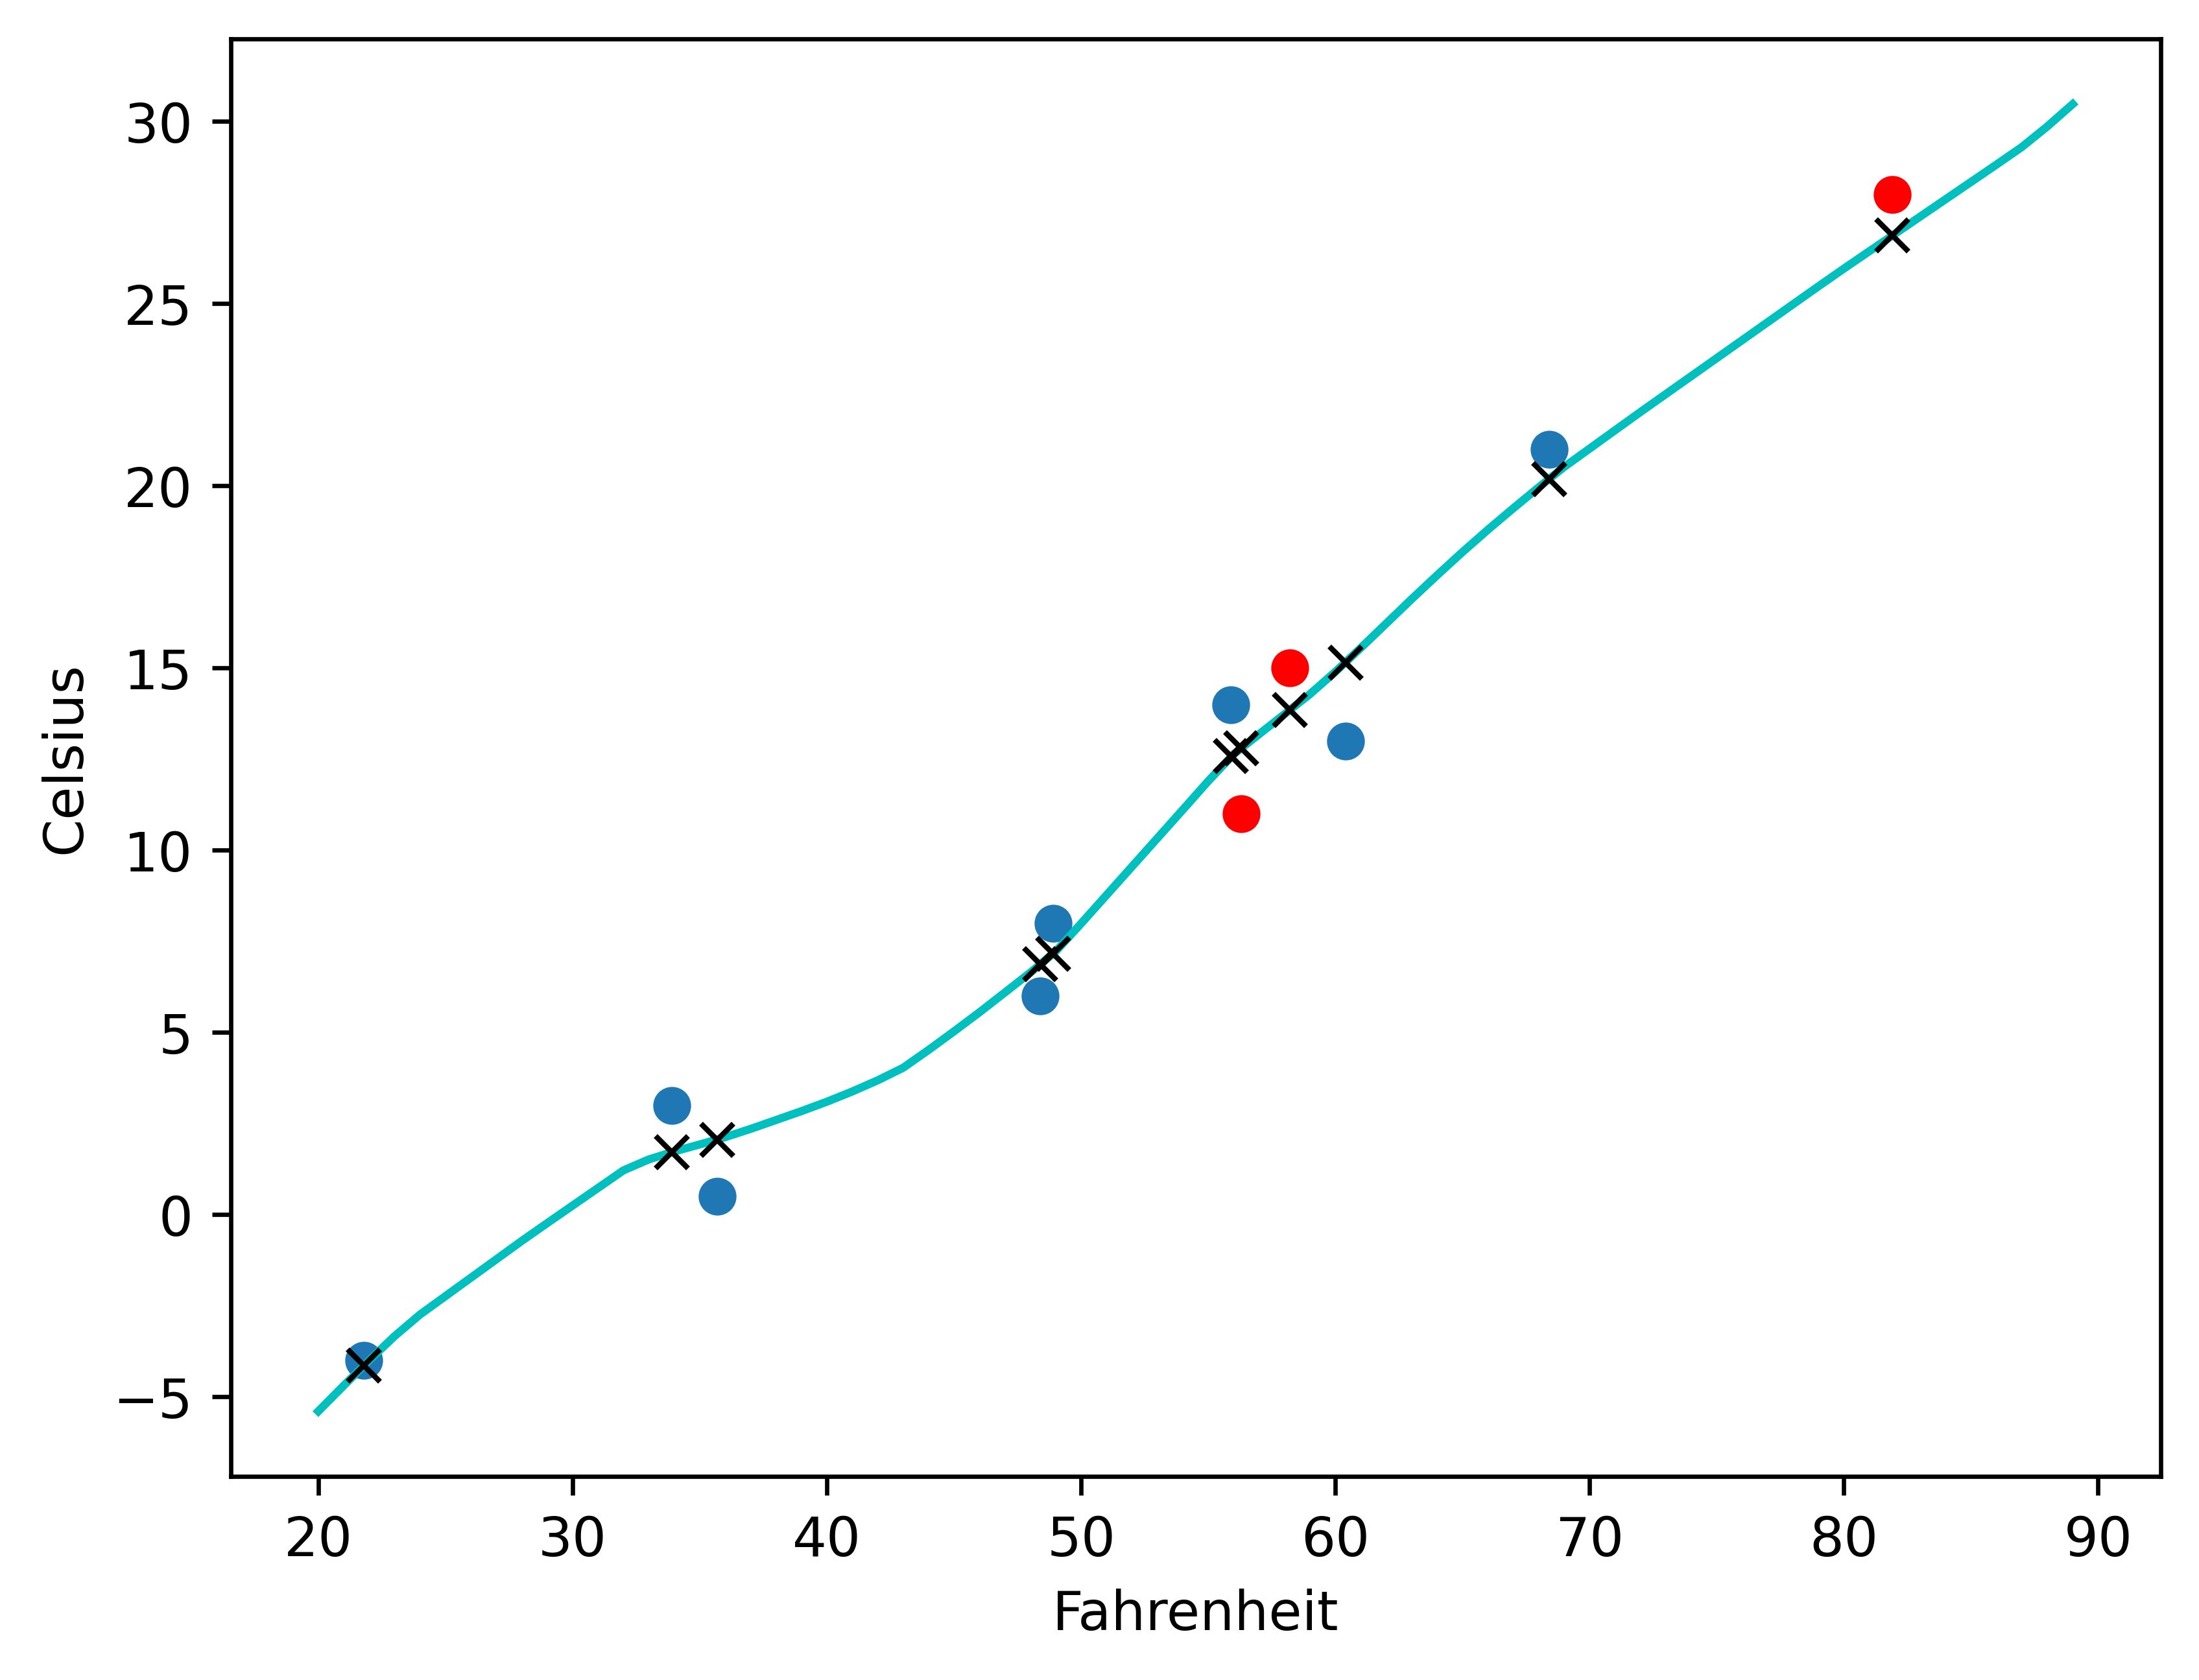

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u[train_indices].numpy(), t_c[train_indices].numpy(), 'o')
plt.plot(t_u[val_indices].numpy(), t_c[val_indices].numpy(), 'ro')
predicted_t_c = seq_model((t_range - t_u_mean) / t_u_std).detach().numpy()
denormalized_predicted_t_c = predicted_t_c * t_c_std.item() + t_c_mean.item()
plt.plot(t_range.numpy(), denormalized_predicted_t_c, 'c-')
predicted_t_c_input = seq_model(t_un.unsqueeze(1)).detach().numpy()
denormalized_predicted_t_c_input = predicted_t_c_input * t_c_std.item() + t_c_mean.item()
plt.plot(t_u.numpy(), denormalized_predicted_t_c_input, 'kx')
plt.show()

Pierwsze dopasowanie sieci neuronowej do danych było dosyć kiepskie - po 1000 iteracji funkcja straty wynosiła ponad 15. Dopasowanie poprawiło się po przejściu na soft shrink oraz zwiększeniu liczby neuronów w warstwie ukrytej do 50.

### Wnioski

W trakcie laboratorium przećwiczyłem implementację prostego modelu sieci neuronowej w PyTorchu. Wykorzystałem do tego celu modele liniowe zawarte w tej bibliotece. Ustaliłem, że najlepiej dobraną funkcją do przedstawionego zadania był soft shrink. Warto zauważyć, że sieć neuronowa zaczęła działać optymalnie dopiero po zwiększeniu liczby neuronów w warstwie ukrytej do 50. W części kodu odpowiadającej za wizualizację chyba był błąd, co przysporzyło mi trudności w debugowaniu.